In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/MedicalDiagnosisDialogue

/content/drive/MyDrive/MedicalDiagnosisDialogue


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
import seaborn as sn

In [ ]:
#Read Data 
data = pd.read_csv("TrainExpImp.csv")

X_data= data.to_numpy()
print(X_data.shape)
y_data = X_data[:, 100]
X_data = X_data[:, :100]

#permutation of the data
rng = np.random.RandomState(0)
permutation = rng.permutation(len(y_data))
features, targets = y_data[permutation], X_data[permutation, :]

X_train, X_test, y_train, y_test = train_test_split(targets, features, test_size=0.2)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 

(1912, 101)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier()
grid = GridSearchCV(clf, random_grid, cv=kf, scoring="neg_log_loss")
grid.fit(X_train, y_train)
grid.best_params_


In [ ]:
#Create a Random Forest Classifier with the data obtained by GridSearchCV
clf=RandomForestClassifier(n_estimators=1000, bootstrap=True, max_depth=35, max_features='sqrt', min_samples_leaf=1, min_samples_split=10)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, y_train)

y_pred=clf.predict(X_test)

In [ ]:
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy TrainExpImp:",metrics.accuracy_score(y_test, y_pred))
# for TrainImpExp training and test

Accuracy TrainExpImp: 0.825065274151436


In [ ]:
# cross-validation
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Cross validation scores:", scores)
print("Mean score:", np.mean(scores))

#Negative Log Loss
scores = cross_val_score(clf, X_train, y_train, cv=kf, scoring="neg_log_loss")
print("neg log loss:", scores)
print("Mean loss:", np.mean(scores))


Cross validation scores: [0.81699346 0.75816993 0.7875817  0.85620915 0.79344262]
Mean score: 0.8024793742633666
neg log loss: [-0.66623926 -0.64359673 -0.74687568 -0.73896026 -0.6593137 ]
Mean loss: -0.6909971236835938


In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 10), scorer = None):
    
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True, scoring=scorer)
    if scorer=='neg_log_loss':
      train_scores = -train_scores
      test_scores = -test_scores
    else:
      train_scores = train_scores
      test_scores = test_scores
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross Validation Score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

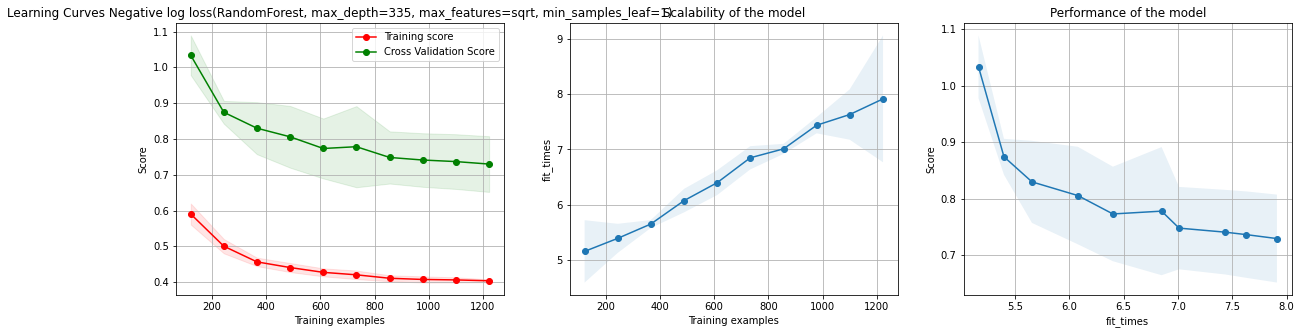

In [ ]:
title = r"Learning Curves Negative log loss(RandomForest, max_depth=335, max_features=sqrt, min_samples_leaf=1)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
clf=RandomForestClassifier(n_estimators=1000, bootstrap=True, max_depth=35, max_features='sqrt', min_samples_leaf=1, min_samples_split=10)
plot_learning_curve(clf, title, X_train, y_train, cv=cv, n_jobs=4, scorer="neg_log_loss")

plt.show()

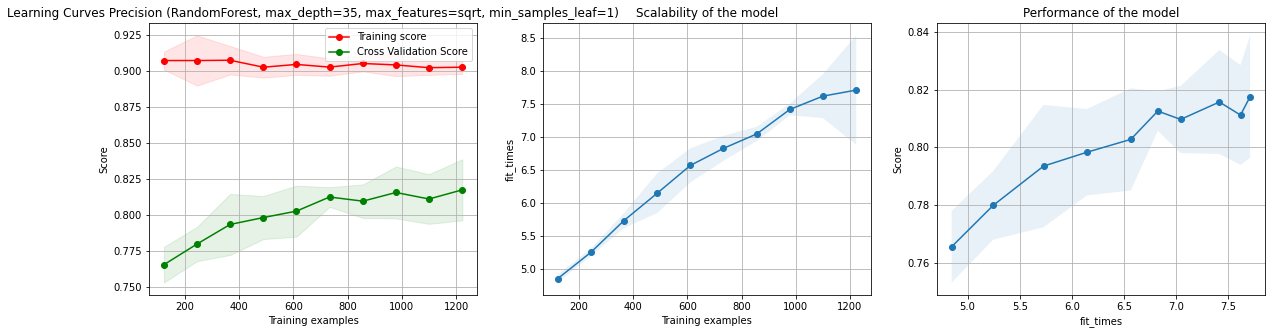

In [ ]:
title = r"Learning Curves Precision (RandomForest, max_depth=35, max_features=sqrt, min_samples_leaf=1)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
clf=RandomForestClassifier(n_estimators=1000, bootstrap=True, max_depth=35, max_features='sqrt', min_samples_leaf=1, min_samples_split=10)
plot_learning_curve(clf, title, X_train, y_train, cv=cv, n_jobs=4, scorer=metrics.make_scorer(metrics.precision_score, average="macro"))

plt.show()

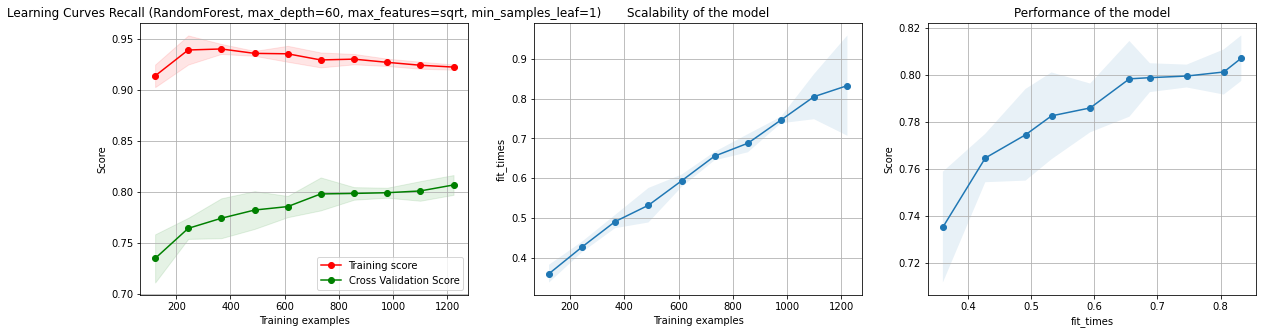

In [ ]:
title = r"Learning Curves Recall (RandomForest, max_depth=60, max_features=sqrt, min_samples_leaf=1)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
clf=RandomForestClassifier(n_estimators=100, bootstrap=False, max_depth=60, max_features='sqrt', min_samples_leaf=1, min_samples_split=10)
plot_learning_curve(clf, title, X_train, y_train, cv=cv, n_jobs=4, scorer=metrics.make_scorer(metrics.recall_score, average="macro"))

plt.show()

In [ ]:
diseaseList = np.empty((0,12))
with open('disease.txt') as f:
    lines = f.readlines()
    for el in lines:
      el = el.replace('\n', '')
      diseaseList = np.append(diseaseList, el)
print(diseaseList)

['Esophagitis' 'Enteritis' 'Asthma' 'Coronary heart disease' 'Pneumonia'
 'Rhinitis' 'Thyroiditis' 'Traumatic brain injury' 'Dermatitis'
 'External otitis' 'Conjunctivitis' 'Mastitis']


In [ ]:
from sklearn import metrics
precision = metrics.precision_score(y_test, y_pred, average="macro")
recall = metrics.recall_score(y_test, y_pred, average="macro")
print(f"precision: {precision}  recall: {recall}")

precision: 0.8304638591756818  recall: 0.8258405688130709


Accuracy: 0.825065274151436


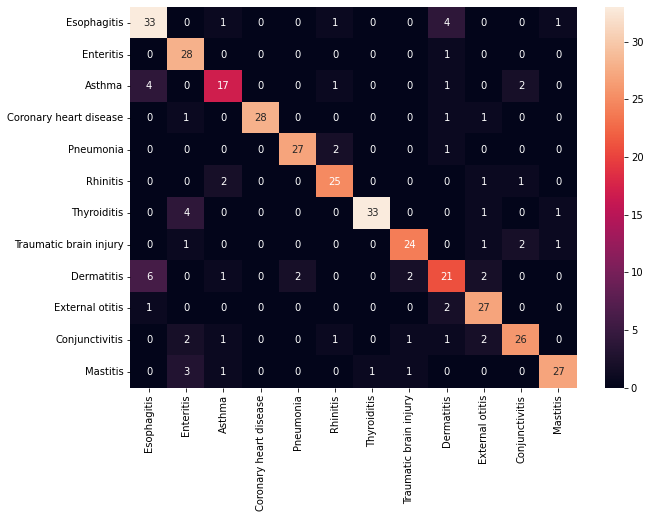

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

conf_mat = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(conf_mat, index = [i for i in diseaseList], columns = [i for i in diseaseList])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
count=0
for i in range(len(y_pred)):
  if y_pred[i] == y_test[i]:
    count += 1
print(f"Accuracy: {count/len(y_pred)}")